In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# from torch.utils.tensorboard import SummaryWriter

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(f'Using device: {device}')
# lam = 0.4  


class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        self.fc2 = nn.Linear(out_features, out_features)
        self.activation = torch.sin
        
        if in_features != out_features:
            self.shortcut = nn.Linear(in_features, out_features)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.activation(self.fc1(x))
        out = self.fc2(out)
        out += identity
        out = self.activation(out)
        return out

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer1 = ResidualBlock(1, 24)
        self.hidden_layer2 = ResidualBlock(24, 17)
        self.hidden_layer3 = ResidualBlock(17, 10)
        self.hidden_layer4 = ResidualBlock(10, 3)
        self.hidden_layer5= ResidualBlock(3, 3)
        self.output_layer = nn.Linear(20, 1)
        self.learned = False 
        
    def forward(self, y):
        y = torch.tanh(self.hidden_layer1(y))
        y = torch.tanh(self.hidden_layer2(y))
        y = torch.tanh(self.hidden_layer3(y))
        y = torch.tanh(self.hidden_layer4(y))
        # y = torch.tanh(self.hidden_layer5(y))
        y = self.output_layer(y)
        return y
    
    def U(self, y):
        return (self(y) - self(-y)) / 2

    def get_lam(self, y):
        if self.learned:
            U = self.U(y)
            U_y = torch.autograd.grad(U, y, grad_outputs=torch.ones_like(U), create_graph=True)[0]
            U_yy = torch.autograd.grad(U_y, y, grad_outputs=torch.ones_like(U_y), create_graph=True)[0]
            return torch.mean(torch.divide(y*U_yy , -(1 + U_y) * U_y - (U + y)*U_yy))
        return .4
    
def f(y,U,U_y,lam):
    return -lam * U + ((1 + lam) * y + U) * U_y

def compute_derivative(f, y, model, lam, orders,finite=False):
    y.requires_grad = True
    U = model.U(y)
    U_y = torch.autograd.grad(U, y, grad_outputs=torch.ones_like(U), create_graph=True)[0]
    lam = model.get_lam(y)
    f_val = f(y, U, U_y, lam)
    h = y[1] - y[0]
    res = []
    if not finite:
        for _ in range(int(orders.max())):
            f_val = torch.autograd.grad(f_val, y, grad_outputs=torch.ones_like(f_val), create_graph=True)[0]
            if _ + 1 in orders:
                res.append(f_val)
    else:
        for _ in range(int(orders.max())):
            f_val = (y[1:] - y[:-1]) / h
            if _ + 1 in orders:
                res.append(f_val)
    return res

def Loss(model, y, collocation_points):
    y.requires_grad = True
    U = model.U(y)
    U_y = torch.autograd.grad(U, y, grad_outputs=torch.ones_like(U), create_graph=True)[0]
    lam = model.get_lam(y)

    # Equation loss
    f_val = f(y, U, U_y,lam)

    # Smooth loss 3rd and fifth derivative
    derivatives = compute_derivative(f,collocation_points,model,lam,np.array([3.0]),True)
    f_yyy = derivatives[0]
    # f_yyyyy = derivatives[1]
 

    # Condition loss U(-2) = 1
    g = model.U(torch.tensor([-2.0], dtype=y.dtype, device=y.device)) - 1
    
    equation_loss = torch.mean(f_val**2)
    condition_loss = torch.mean(g**2)

    total_loss = equation_loss + condition_loss + 1e-3*torch.mean(f_yyy**2) #+ 1e-5*torch.mean(f_yyyyy**2)
    return total_loss

Using device: cpu


### Fixed lambda 

In [21]:
model = PINN().to(device)
# model = torch.compile(model)
optimizer = optim.LBFGS(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

'''
 Load the model if needed
'''
# model.load_state_dict(torch.load('model.pth'))
# optimizer.load_state_dict(torch.load('optimizer.pth'))
# model.eval()  
# model.train()  

num_epochs = 10000
y_data = torch.linspace(-2,2,10000).view(-1,1).to(device)
# y_data = (y_data-y_data.mean()) / y_data.std()

# writer = SummaryWriter()
Ns = 1000
collocation_points = torch.FloatTensor(Ns).uniform_(-1, 1).view(-1, 1).to(device)
collocation_points = (collocation_points-collocation_points.mean()) / collocation_points.std()

def closure():
    optimizer.zero_grad() # Clear the gradients
    loss = Loss(model, y_data,collocation_points) # Compute the loss
    loss.backward() # Backward pass
    return loss

for epoch in range(num_epochs):
    # y_data = torch.FloatTensor(10000).uniform_(-2, 2).view(-1, 1).to(device)

    optimizer.zero_grad()
    loss = Loss(model, y_data, collocation_points)
    loss.backward()
    optimizer.step(closure)
    if epoch % 100 == 0:
        print(f'epoch {epoch} loss {loss.item()}') 
    # writer.add_scalar(f'Training Loss_1', loss.item(), epoch)
    if loss.item() <= 1e-8:
        break

epoch 0 loss 0.8036672472953796
epoch 100 loss 0.0008120102575048804
epoch 200 loss 0.0008106219465844333
epoch 300 loss 0.0008105480810627341
epoch 400 loss 0.0008104860316962004
epoch 500 loss 0.0008104309672489762
epoch 600 loss 0.000810380035545677
epoch 700 loss 0.0008103321306407452
epoch 800 loss 0.000810285855550319
epoch 900 loss 0.0008102411520667374
epoch 1000 loss 0.0008101975545287132
epoch 1100 loss 0.0008101545972749591
epoch 1200 loss 0.0008101123385131359
epoch 1300 loss 0.000810070603620261
epoch 1400 loss 0.0008100294508039951
epoch 1500 loss 0.0008099889964796603
epoch 1600 loss 0.0008099490660242736
epoch 1700 loss 0.0008099088445305824
epoch 1800 loss 0.000809868797659874
epoch 1900 loss 0.0008098292164504528
epoch 2000 loss 0.0008097896352410316
epoch 2100 loss 0.0008097502286545932
epoch 2200 loss 0.0008097109384834766
epoch 2300 loss 0.0008096718229353428
epoch 2400 loss 0.000809632649179548
epoch 2500 loss 0.0008095935918390751
epoch 2600 loss 0.00080955476732

### Lambda learned in the process

In [22]:
model.learned = True

for epoch in range(num_epochs):
    # y_data = torch.FloatTensor(10000).uniform_(-2, 2).view(-1, 1).to(device)

    optimizer.zero_grad()
    loss = Loss(model, y_data, collocation_points)
    loss.backward()
    optimizer.step(closure)
    if epoch % 100 == 0:
        print(f'epoch {epoch} loss {loss.item()}') 
    # writer.add_scalar(f'Training Loss_1', loss.item(), epoch)
    if loss.item() <= 1e-8:
        break

epoch 0 loss 0.4529871642589569
epoch 100 loss nan
epoch 200 loss nan


KeyboardInterrupt: 

In [6]:
# Save the model 
model_path = 'model_nbatch_first.pth'
optimizer_path = 'optimizer_nbatch_first.pth'

torch.save(model.state_dict(), model_path)

torch.save(optimizer.state_dict(), optimizer_path)

1.0543102
tensor(0.0142, grad_fn=<SqrtBackward0>)


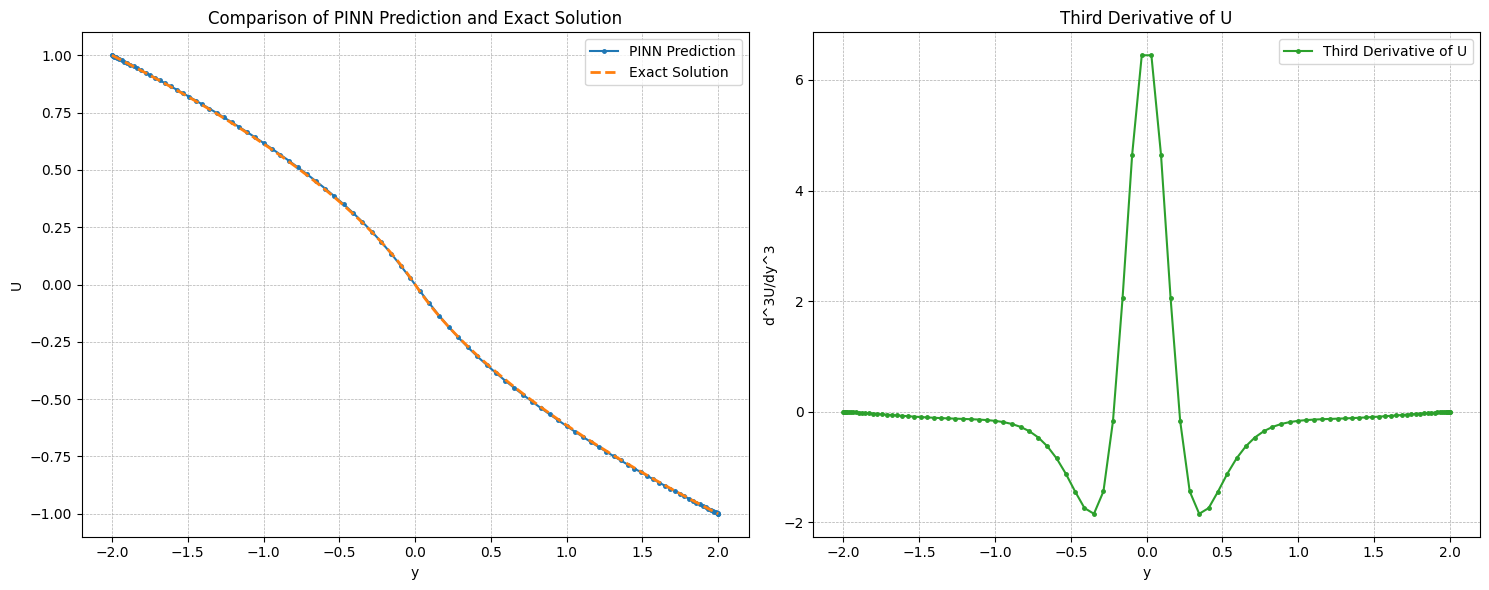

In [5]:
y_test = 2*torch.sin(torch.linspace(-np.pi/2, np.pi/2, 100)).view(-1, 1).to(device)
y_test.requires_grad = True
# Get model predictions and detach to move to CPU
U_pred = model.U(y_test)
U_pred_y = torch.autograd.grad(U_pred, y_test, grad_outputs=torch.ones_like(U_pred), create_graph=True)[0]
U_pred_yy = torch.autograd.grad(U_pred_y, y_test, grad_outputs=torch.ones_like(U_pred_y), create_graph=True)[0]
U_pred_yyy = torch.autograd.grad(U_pred_yy, y_test, grad_outputs=torch.ones_like(U_pred_yy), create_graph=True)[0]
U_pred_yyyy = torch.autograd.grad(U_pred_yyy, y_test, grad_outputs=torch.ones_like(U_pred_yyy), create_graph=True)[0]
U_pred_yyyyy = torch.autograd.grad(U_pred_yyyy, y_test, grad_outputs=torch.ones_like(U_pred_yyyy), create_graph=True)[0]

lam = model.get_lam(y_test).detach().cpu().numpy()
print(lam)
residual = f(y_test,U_pred,U_pred_y,lam)
print(torch.sqrt(torch.mean(residual**2)))
U_pred = U_pred.detach().cpu().numpy()
# Generate exact solution using implicit formula
U_positive = np.linspace(0, 1, 100)
y_true = np.array([U_positive + U_positive**(1 + 1/lam), -U_positive - U_positive**(1 + 1/lam)]).flatten()
order = y_true.argsort()
U_sorted = np.array([-U_positive, U_positive]).flatten()[order]

y_sorted = y_true[order]

# Convert test data to numpy
y_test_np = y_test.detach().cpu().numpy()

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot the PINN Prediction vs Exact Solution
ax1.plot(y_test_np, U_pred, '.-', label='PINN Prediction', color='#1f77b4', markersize=5)
ax1.plot(y_sorted, U_sorted, label='Exact Solution', color='#ff7f0e', linestyle='--', linewidth=2)
ax1.set_title('Comparison of PINN Prediction and Exact Solution')
ax1.set_xlabel('y')
ax1.set_ylabel('U')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.legend()

# Plot the third derivative
ax2.plot(y_test_np, U_pred_yyy.detach().cpu().numpy(), '.-', label='Third Derivative of U', color='#2ca02c', markersize=5)
ax2.set_title('Third Derivative of U')
ax2.set_xlabel('y')
ax2.set_ylabel('d^3U/dy^3')
ax2.grid(True, which='both', linestyle='--', linewidth=0.51)
ax2.legend()

plt.tight_layout()
plt.show()